# <font color='violet'> Feature Engineering for Review Language 

On data that I started pre-processing here: https://github.com/fractaldatalearning/psychedelic_efficacy/blob/main/notebooks/5-kl-studies-lang-eda-preprocess.ipynb
    
Try multiple methods for engineering features out of the text of the reviews. 

In [1]:
# ! python -m spacy download en_core_web_lg
# ! pip install gensim

In [2]:
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import spacy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from gensim.models.fasttext import FastText, load_facebook_model
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

# Might need to do this:
# import fasttext.util
# fasttext.util.download_model('en', if_exists='ignore')  # English
# ft = fasttext.load_model('cc.en.300.bin')

In [3]:
df = pd.read_csv('../data/interim/studies_w_sentiment.csv').drop(columns=['Unnamed: 0'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31559 entries, 0 to 31558
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rating             31559 non-null  float64
 1   condition          31559 non-null  object 
 2   review             31559 non-null  object 
 3   date               31451 non-null  object 
 4   drug0              31559 non-null  object 
 5   drug1              18992 non-null  object 
 6   review_len         31559 non-null  int64  
 7   complexity         31559 non-null  float64
 8   spell_corr         31559 non-null  object 
 9   no_stops_lemm      31558 non-null  object 
 10  no_stop_cap_lemm   31558 non-null  object 
 11  subjectivity       31559 non-null  float64
 12  original_polarity  31559 non-null  float64
dtypes: float64(4), int64(1), object(8)
memory usage: 3.1+ MB


In [4]:
# I'll just be using the cleanest text
df = df.drop(columns=['review', 'spell_corr', 'no_stops_lemm'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31559 entries, 0 to 31558
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rating             31559 non-null  float64
 1   condition          31559 non-null  object 
 2   date               31451 non-null  object 
 3   drug0              31559 non-null  object 
 4   drug1              18992 non-null  object 
 5   review_len         31559 non-null  int64  
 6   complexity         31559 non-null  float64
 7   no_stop_cap_lemm   31558 non-null  object 
 8   subjectivity       31559 non-null  float64
 9   original_polarity  31559 non-null  float64
dtypes: float64(4), int64(1), object(5)
memory usage: 2.4+ MB


I'll start by engineering features with tfidf. Based on what I found during eda, ngrams through n=4 provided meaningful-seeming phrases, but apart from !!!!, the most commonly-occuring quadgram "post traumatic stress disorder" only appeared in less than 1% of reviews. While ptsd could very likely appear later in scrubbed psychedelic experience reports, other quadgrams are unlikely to improve model performance enough to make it worth the over-fitting that comes with including them. So, for tfidf, focus on ngrams 1-3. 

Speaking of exclamation points, I'd wanted to get rid of exccessive exclamations and reduce each instance to just 3 !!!. Do that real quick, and clean up and null values. I'd kept some null values in place earlier on until I more thoroughly understood the data/ was ready to create a train-test split, and that time has come. With everything clean, things will go smoother with modeling to test out various feature engineering techniques. 

In [5]:
# It appears as though stopword deletion left one very short review consisting of nothing
# Drop that row, then reset the index so it's in order, in order to replace !!!!. 
df[df.no_stop_cap_lemm.isnull()]

,rating,condition,date,drug0,drug1,review_len,complexity,no_stop_cap_lemm,subjectivity,original_polarity
29472,8.0,anxiety,2016-10-19,clonazepam,NaN,7,-3.5,NaN,0.0,0.0


In [6]:
df = df.drop(labels=29472).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31558 entries, 0 to 31557
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rating             31558 non-null  float64
 1   condition          31558 non-null  object 
 2   date               31450 non-null  object 
 3   drug0              31558 non-null  object 
 4   drug1              18992 non-null  object 
 5   review_len         31558 non-null  int64  
 6   complexity         31558 non-null  float64
 7   no_stop_cap_lemm   31558 non-null  object 
 8   subjectivity       31558 non-null  float64
 9   original_polarity  31558 non-null  float64
dtypes: float64(4), int64(1), object(5)
memory usage: 2.4+ MB


In [7]:
# That worked. Find some exclamation points that need replacing.
df[df.no_stop_cap_lemm.str.find('!!!!!!')!=-1]

,rating,condition,date,drug0,drug1,review_len,complexity,no_stop_cap_lemm,subjectivity,original_polarity
9255,7.0,addiction,2016-08-28,varenicline,chantix,763,4.1,want let everyone know react chantexday 7 8 so...,0.736111,-0.364583


In [8]:
df.no_stop_cap_lemm[9255]

'want let everyone know react chantexday 7 8 soon tired desire mad angry confused know ! get sleep tell need bed set bed ! think computer desk study ! 4 pm asleep 10 time wake all want sleep tired doctoream color tired thankfully hit weekend tomorrow work ! hopefully able ! worry have cigarette anymore really fierceness quit get smoke!!!!!!quit numb'

In [9]:
exclamation_replacement = {'!!!!':'!!!', '!!!!!':'!!!', '!!!!!!':'!!!',
                            '!!!!!!!':'!!!', '!!!!!!!!':'!!!'}

for row in tqdm(range(len(df))):
    str_to_reduce_exclam = df.loc[row,'no_stop_cap_lemm']
    for key, value in exclamation_replacement.items():
        str_to_reduce_exclam = str_to_reduce_exclam.replace(key,value)
    df.loc[row,'no_stop_cap_lemm'] = str_to_reduce_exclam
        
df.no_stop_cap_lemm[9255]

100%|██████████| 31558/31558 [00:20<00:00, 1560.27it/s]


'want let everyone know react chantexday 7 8 soon tired desire mad angry confused know ! get sleep tell need bed set bed ! think computer desk study ! 4 pm asleep 10 time wake all want sleep tired doctoream color tired thankfully hit weekend tomorrow work ! hopefully able ! worry have cigarette anymore really fierceness quit get smoke!!!quit numb'

That worked, move on. 

<font color='violet'> Deal with null values. 

In [10]:
# It appears as though stopword deletion left one very short review consisting of nothing
# Drop that row, then reset the index so it's in order. 
df[df.no_stop_cap_lemm.isnull()]

,rating,condition,date,drug0,drug1,review_len,complexity,no_stop_cap_lemm,subjectivity,original_polarity


In [11]:
df = df.drop(labels=29472).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31557 entries, 0 to 31556
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rating             31557 non-null  float64
 1   condition          31557 non-null  object 
 2   date               31449 non-null  object 
 3   drug0              31557 non-null  object 
 4   drug1              18991 non-null  object 
 5   review_len         31557 non-null  int64  
 6   complexity         31557 non-null  float64
 7   no_stop_cap_lemm   31557 non-null  object 
 8   subjectivity       31557 non-null  float64
 9   original_polarity  31557 non-null  float64
dtypes: float64(4), int64(1), object(5)
memory usage: 2.4+ MB


In [12]:
# There are rows without values for drug1; just replace nan with the string "na"
df['drug1'] = df.drug1.fillna('na')
df.isnull().any()

rating               False
condition            False
date                  True
drug0                False
drug1                False
review_len           False
complexity           False
no_stop_cap_lemm     False
subjectivity         False
original_polarity    False
dtype: bool

There are missing dates. I don't want to introduce leakage by imputing missing values with the most common date overall, but I can start with the train_test_split and just impute all missing dates with the most common date from the training set. 

In [13]:
# First, turn the date column into a date type
df['date'] = pd.to_datetime(df.date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31557 entries, 0 to 31556
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   rating             31557 non-null  float64       
 1   condition          31557 non-null  object        
 2   date               31449 non-null  datetime64[ns]
 3   drug0              31557 non-null  object        
 4   drug1              31557 non-null  object        
 5   review_len         31557 non-null  int64         
 6   complexity         31557 non-null  float64       
 7   no_stop_cap_lemm   31557 non-null  object        
 8   subjectivity       31557 non-null  float64       
 9   original_polarity  31557 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(4)
memory usage: 2.4+ MB


In [14]:
X = df.drop(columns='rating')
y = df.rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17, 
                                                    stratify=y)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22089 entries, 3172 to 30071
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   condition          22089 non-null  object        
 1   date               22010 non-null  datetime64[ns]
 2   drug0              22089 non-null  object        
 3   drug1              22089 non-null  object        
 4   review_len         22089 non-null  int64         
 5   complexity         22089 non-null  float64       
 6   no_stop_cap_lemm   22089 non-null  object        
 7   subjectivity       22089 non-null  float64       
 8   original_polarity  22089 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 1.7+ MB


In [15]:
X_train.date.value_counts(ascending=False)

2016-02-21    28
2016-01-14    24
2017-01-25    23
2017-01-18    22
2015-10-12    22
              ..
2010-01-14     1
2010-02-16     1
2008-11-12     1
2009-04-15     1
2009-03-14     1
Name: date, Length: 3503, dtype: int64

In [16]:
X_train['date'] = X_train.date.fillna('2016-02-21')
X_test['date'] = X_test.date.fillna('2016-02-21')
X_train.isnull().any()

condition            False
date                 False
drug0                False
drug1                False
review_len           False
complexity           False
no_stop_cap_lemm     False
subjectivity         False
original_polarity    False
dtype: bool

In [17]:
X_test.isnull().any()

condition            False
date                 False
drug0                False
drug1                False
review_len           False
complexity           False
no_stop_cap_lemm     False
subjectivity         False
original_polarity    False
dtype: bool

In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22089 entries, 3172 to 30071
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   condition          22089 non-null  object        
 1   date               22089 non-null  datetime64[ns]
 2   drug0              22089 non-null  object        
 3   drug1              22089 non-null  object        
 4   review_len         22089 non-null  int64         
 5   complexity         22089 non-null  float64       
 6   no_stop_cap_lemm   22089 non-null  object        
 7   subjectivity       22089 non-null  float64       
 8   original_polarity  22089 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 1.7+ MB


Ready to carry on with feature engineering

<font color='violet'> Implement tfidf 
    
I'll need to quickly create and evaluate a model after implementing each method of feature extraction from the no_stop_cap_lemm text. I'll do model tuning later, but for now, my understanding is that naive bayes is a common, solid model for nlp classification tasks, so I'll use that to compare various preprocessing techniques explored here. 
    
I'll start by modeling with just the extracted text features. These could be recombined with the other columns later (once they're encoded numerically) for improved model performance if I have some reason to do so. But I don't want to do all my modeling including variables like drugs and conditions, because those features will be absent from scraped psychedelic experience reports. 

In [19]:
X_train_models = X_train.drop(columns=['condition', 'date', 'drug0', 'drug1'])
X_test_models = X_test.drop(columns=['condition', 'date', 'drug0', 'drug1'])
X_train_models.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22089 entries, 3172 to 30071
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   review_len         22089 non-null  int64  
 1   complexity         22089 non-null  float64
 2   no_stop_cap_lemm   22089 non-null  object 
 3   subjectivity       22089 non-null  float64
 4   original_polarity  22089 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 1.0+ MB


In [20]:
# Specifically, to get tfidf feature engineering to work, pare it down to just text column
X_train_tfidf = X_train_models.no_stop_cap_lemm
X_test_tfidf = X_test_models.no_stop_cap_lemm
X_train_tfidf.head()

3172                                     good give run gas
21607    75 mg x daily no noticeable effect 150 mg x da...
28990    take 145 mg 10 year fantastic insomnia really ...
23881    help stability mood help insomnia start experi...
16374                                  crazy eat sleep sit
Name: no_stop_cap_lemm, dtype: object

In [21]:
# Could change parametes to include min_df, max_df, but for now just use a simple version
tfidf = TfidfVectorizer(ngram_range=(1, 3), lowercase=False)

# Fit to training set, and transform both sets
X_train_tfidf = tfidf.fit_transform(X_train_tfidf)
X_test_tfidf = tfidf.transform(X_test_tfidf)

# Run through a model to evaluate accuracy
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf, y_train)
pred = nb_clf.predict_proba(X_test_tfidf)
metrics.roc_auc_score(y_test, pred, multi_class='ovr')

0.6055234472676633

With only the text itself and no additional features such as sentiment polarity, which is quite well-correlated with rating, the area under the curve is 0.6. Try some other methods for feature engineering with the text column. 

<font color='violet'> Implement feature engineering with CountVectorizer 

In [22]:
# Copy to create relevant train and test sets
X_train_cvect = X_train_models.no_stop_cap_lemm
X_test_cvect = X_test_models.no_stop_cap_lemm

# Instantiate count vectorizer
cvect = CountVectorizer(lowercase=False)

# Fit to training set, and transform both sets
X_train_cvect = cvect.fit_transform(X_train_cvect)
X_test_cvect = cvect.transform(X_test_cvect)

# Run through a model to evaluate accuracy
nb_clf = MultinomialNB()
nb_clf.fit(X_train_cvect, y_train)
pred = nb_clf.predict_proba(X_test_cvect)
metrics.roc_auc_score(y_test, pred, multi_class='ovr')

0.6497113011239557

The features created by the count vectorizer worked better with the model than those from tfidf. Given that individual words rather than bigrams or trigrams as arranged here are more likely to show up in unseen data from psychedelic experience reports, it also makes sense to favor count vectorizer from a perspective of avoiding overfitting. I could even explore tuning hyperparameters such that bi- and tri-grams of characters rather than even whole words are counted, which would make CountVectorizer more similar to more complex word embedding strategies and more applicable to unseen data. 

Finally, generate word embeddings. There are multiple methods with which to do this such as spacy's pretrained models, Word2Vec, GloVe, or FastText. I'm unsure about relative usability or performance, so play around. I did read that FastText is better for generalization to unknown words than Word2Vec or GloVe, so definitely go there and see if it's feasible, after starting with the simplest tool, spacy. 

<font color='violet'> Explore word embedding 

In [23]:
# Start with just using the spacy vector value to get average token vectors for each review. 

nlp = spacy.load('en_core_web_lg') 
df['vector'] = df['no_stop_cap_lemm'].apply(nlp).apply(lambda text: np.mean([token.vector for 
                                                                             token in text]))
df.head()

,rating,condition,date,drug0,drug1,review_len,complexity,no_stop_cap_lemm,subjectivity,original_polarity,vector
0,9.0,add,NaT,vyvanse,na,793,10.4,begin take 20 mg vyvanse month surprised find ...,0.461111,0.039286,-0.088692
1,8.0,add,NaT,dextroamphetamine,na,795,8.0,twitch adderall dexedoctorine compare effect d...,0.501837,0.140464,-0.020730
2,8.0,adhd,NaT,vyvanse,na,446,2.9,vyvanse 2 week start 40 60 week probably upper...,0.241667,0.010667,-0.055985
3,8.0,fatigue,NaT,saizen,na,508,14.1,1 subcutaneous injection somatropin abdoman in...,0.348810,0.320000,-0.043427
4,3.0,dementia,NaT,zyprexa,na,417,11.5,many diseaselewy body syndoctorome dementia ta...,0.466667,0.000000,-0.026450


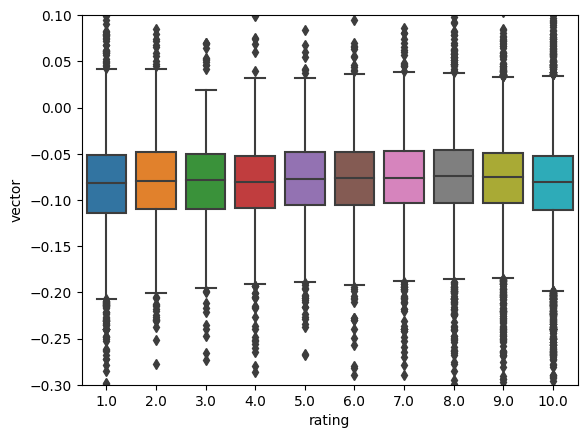

In [24]:
# Is this vector column correlated with the ratings column? 
sns.boxplot(data=df, x='rating', y='vector').set(ylim=(-0.3,0.1))
plt.show()

It appears as though the mean word vector value for each review isn't very meaningful on its own. However, what about columns that contains each review's similarity to a mega-review that is made up of all of the test set's reviews for just rating 1, rating 2, rating 3, etc? 

<font color='violet'> Create columns for vector similarity with meta-reviews based on each rating. 
    
Create meta-reviews per rating based on training data only. 

In [25]:
X_train['set'] = 'train'
X_test['set'] = 'test'
train_set = pd.concat([X_train, y_train], axis=1)
train_set.head()

,condition,date,drug0,drug1,review_len,complexity,no_stop_cap_lemm,subjectivity,original_polarity,set,rating
3172,anxiety,2013-12-14,escitalopram,lexapro,36,-1.2,good give run gas,0.600000,0.700000,train,9.0
21607,anxiety,2017-03-13,pregabalin,na,547,5.4,75 mg x daily no noticeable effect 150 mg x da...,0.343056,0.031439,train,8.0
28990,depression,2016-10-16,mirtazapine,na,390,4.8,take 145 mg 10 year fantastic insomnia really ...,0.591667,0.096296,train,8.0
23881,bpd,2017-08-16,quetiapine,na,156,8.2,help stability mood help insomnia start experi...,1.000000,-1.000000,train,7.0
16374,depression,2014-09-19,fluoxetine,prozac,66,-0.4,crazy eat sleep sit,0.900000,-0.600000,train,2.0


In [33]:
rating_10_meta = ' '.join(train_set[train_set['rating']==10]['no_stop_cap_lemm'])
rating_10_meta = nlp(rating_10_meta[:100000])

# Save this for use in later models.
with open('../data/processed/rating_10_meta.txt','w') as file:
    file.write(str(rating_10_meta))

In [26]:
rating_9_meta = ' '.join(train_set[train_set['rating']==9]['no_stop_cap_lemm'])
rating_9_meta = nlp(rating_9_meta[:100000])

rating_8_meta = ' '.join(train_set[train_set['rating']==8]['no_stop_cap_lemm'])
rating_8_meta = nlp(rating_8_meta[:100000])

rating_7_meta = ' '.join(train_set[train_set['rating']==7]['no_stop_cap_lemm'])
rating_7_meta = nlp(rating_7_meta[:100000])

rating_6_meta = ' '.join(train_set[train_set['rating']==6]['no_stop_cap_lemm'])
rating_6_meta = nlp(rating_6_meta[:100000])

rating_5_meta = ' '.join(train_set[train_set['rating']==5]['no_stop_cap_lemm'])
rating_5_meta = nlp(rating_5_meta[:100000])

rating_4_meta = ' '.join(train_set[train_set['rating']==4]['no_stop_cap_lemm'])
rating_4_meta = nlp(rating_4_meta[:100000])

rating_3_meta = ' '.join(train_set[train_set['rating']==3]['no_stop_cap_lemm'])
rating_3_meta = nlp(rating_3_meta[:100000])

rating_2_meta = ' '.join(train_set[train_set['rating']==2]['no_stop_cap_lemm'])
rating_2_meta = nlp(rating_2_meta[:100000])

rating_1_meta = ' '.join(train_set[train_set['rating']==1]['no_stop_cap_lemm'])
rating_1_meta = nlp(rating_1_meta[:100000])

print(len(rating_2_meta), len(rating_2_meta), len(rating_3_meta), len(rating_4_meta), 
      len(rating_5_meta), len(rating_6_meta), len(rating_7_meta), len(rating_8_meta), 
      len(rating_9_meta), len(rating_10_meta))

15583 15583 15672 15783 15680 15712 15599 15663 15529 15790


For the entire dataset, now that each rating_n_meta doc contains only text from the training set, add a column and fill with each review's similarity to each meta-review. 

In [27]:
test_set = pd.concat([X_test, y_test], axis=1)
df = pd.concat([train_set, test_set])
df.sample(5)

,condition,date,drug0,drug1,review_len,complexity,no_stop_cap_lemm,subjectivity,original_polarity,set,rating
22985,depression,2015-12-22,bupropion,wellbutrin,781,6.4,18 year old start take wellbutrin 3 month ago ...,0.416667,0.069444,train,8.0
23599,anxiety,2008-12-26,prazosin,na,390,5.3,use ptsd anxiety nightmare etc previously try ...,0.277778,0.008333,test,10.0
18468,addiction,2012-01-06,acamprosate,campral,583,5.5,30 year old female battle alcohol many year do...,0.419167,0.320000,train,10.0
1326,insomnia,2016-07-07,suvorexant,belsomra,750,6.7,try lunesta alien trazodone insomnia work than...,0.597763,0.021108,train,10.0
26489,bipolar,2015-03-01,lamotrigine,na,101,6.4,good meditation have bipolar give confidence c...,0.600000,1.000000,test,10.0


In [28]:
# Create the columns
df['similarity_w_10'] = df.no_stop_cap_lemm.apply(nlp).apply(
    lambda text: text.similarity(rating_10_meta))

df['similarity_w_9'] = df.no_stop_cap_lemm.apply(nlp).apply(
    lambda text: text.similarity(rating_9_meta))

df['similarity_w_8'] = df.no_stop_cap_lemm.apply(nlp).apply(
    lambda text: text.similarity(rating_8_meta))

df['similarity_w_7'] = df.no_stop_cap_lemm.apply(nlp).apply(
    lambda text: text.similarity(rating_7_meta))

df['similarity_w_6'] = df.no_stop_cap_lemm.apply(nlp).apply(
    lambda text: text.similarity(rating_6_meta))

df['similarity_w_5'] = df.no_stop_cap_lemm.apply(nlp).apply(
    lambda text: text.similarity(rating_5_meta))

df['similarity_w_4'] = df.no_stop_cap_lemm.apply(nlp).apply(
    lambda text: text.similarity(rating_4_meta))

df['similarity_w_3'] = df.no_stop_cap_lemm.apply(nlp).apply(
    lambda text: text.similarity(rating_3_meta))

df['similarity_w_2'] = df.no_stop_cap_lemm.apply(nlp).apply(
    lambda text: text.similarity(rating_2_meta))

df['similarity_w_1'] = df.no_stop_cap_lemm.apply(nlp).apply(
    lambda text: text.similarity(rating_1_meta))

df.head()

/var/folders/xz/sq63wkqx22q0t_hr7_1jfrhr0000gn/T/ipykernel_4435/2076254851.py:3: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  lambda text: text.similarity(rating_10_meta))
/var/folders/xz/sq63wkqx22q0t_hr7_1jfrhr0000gn/T/ipykernel_4435/2076254851.py:6: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  lambda text: text.similarity(rating_9_meta))
/var/folders/xz/sq63wkqx22q0t_hr7_1jfrhr0000gn/T/ipykernel_4435/2076254851.py:9: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  lambda text: text.similarity(rating_8_meta))
/var/folders/xz/sq63wkqx22q0t_hr7_1jfrhr0000gn/T/ipykernel_4435/2076254851.py:12: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  lambda text: text.similarity(rating_7_meta))
/var/folders/xz/sq63wkqx22q0t_hr7_1jfrhr0000gn/T/ipykernel_4435/2076254851.py:15: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  lambda text: text.similarity(rating_6_meta))
/var/fo

,condition,date,drug0,drug1,review_len,complexity,no_stop_cap_lemm,subjectivity,original_polarity,set,...,similarity_w_10,similarity_w_9,similarity_w_8,similarity_w_7,similarity_w_6,similarity_w_5,similarity_w_4,similarity_w_3,similarity_w_2,similarity_w_1
3172,anxiety,2013-12-14,escitalopram,lexapro,36,-1.2,good give run gas,0.600000,0.700000,train,...,0.640050,0.634459,0.637919,0.635768,0.634801,0.634340,0.640152,0.641377,0.641142,0.645604
21607,anxiety,2017-03-13,pregabalin,na,547,5.4,75 mg x daily no noticeable effect 150 mg x da...,0.343056,0.031439,train,...,0.841263,0.850843,0.855461,0.855266,0.856042,0.858260,0.855610,0.848723,0.849097,0.839889
28990,depression,2016-10-16,mirtazapine,na,390,4.8,take 145 mg 10 year fantastic insomnia really ...,0.591667,0.096296,train,...,0.922576,0.929451,0.930742,0.929888,0.930491,0.931889,0.927173,0.923545,0.923686,0.916180
23881,bpd,2017-08-16,quetiapine,na,156,8.2,help stability mood help insomnia start experi...,1.000000,-1.000000,train,...,0.825203,0.830641,0.825423,0.824707,0.823785,0.824721,0.822876,0.824725,0.824692,0.823800
16374,depression,2014-09-19,fluoxetine,prozac,66,-0.4,crazy eat sleep sit,0.900000,-0.600000,train,...,0.467668,0.462199,0.469501,0.470684,0.475591,0.484710,0.497155,0.490050,0.495104,0.504138


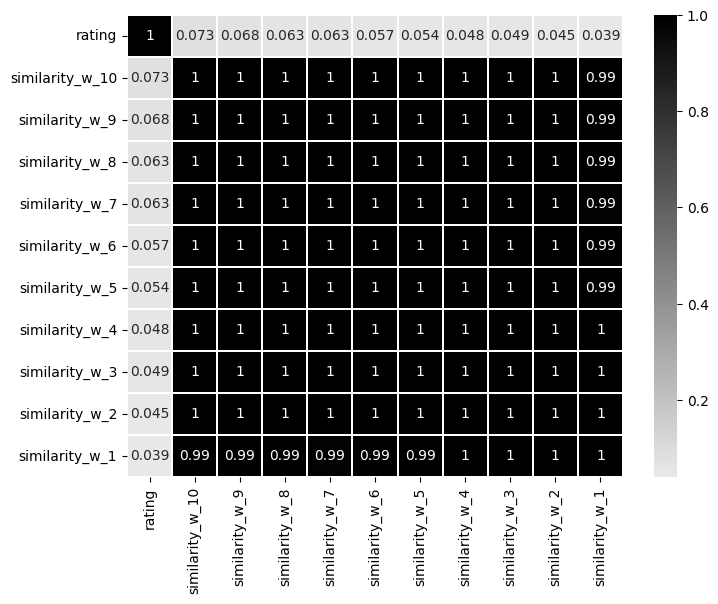

In [29]:
plt.figure(figsize=(8,6))
cmap = sns.diverging_palette(h_neg=0, h_pos=0, s=0, l=0, as_cmap=True)
sns.heatmap(df[['rating', 'similarity_w_10', 'similarity_w_9', 'similarity_w_8', 
                'similarity_w_7', 'similarity_w_6', 'similarity_w_5', 'similarity_w_4', 
                'similarity_w_3', 'similarity_w_2', 'similarity_w_1']].corr(), 
            linewidths=.1, cmap=cmap, center=0.0, annot=True)
plt.yticks(rotation=0);

These columns are highly correlated with one another. Keep just the one column that has the highest correlation with rating, "similarity_w_10"

In [30]:
df = df.drop(columns=['similarity_w_9', 'similarity_w_8', 'similarity_w_7', 'similarity_w_6', 
                      'similarity_w_5', 'similarity_w_4', 'similarity_w_3', 'similarity_w_2', 
                      'similarity_w_1'])
df.head()

,condition,date,drug0,drug1,review_len,complexity,no_stop_cap_lemm,subjectivity,original_polarity,set,rating,similarity_w_10
3172,anxiety,2013-12-14,escitalopram,lexapro,36,-1.2,good give run gas,0.600000,0.700000,train,9.0,0.640050
21607,anxiety,2017-03-13,pregabalin,na,547,5.4,75 mg x daily no noticeable effect 150 mg x da...,0.343056,0.031439,train,8.0,0.841263
28990,depression,2016-10-16,mirtazapine,na,390,4.8,take 145 mg 10 year fantastic insomnia really ...,0.591667,0.096296,train,8.0,0.922576
23881,bpd,2017-08-16,quetiapine,na,156,8.2,help stability mood help insomnia start experi...,1.000000,-1.000000,train,7.0,0.825203
16374,depression,2014-09-19,fluoxetine,prozac,66,-0.4,crazy eat sleep sit,0.900000,-0.600000,train,2.0,0.467668


Several of these columns so far, if combined with the feature engineering done by CountVectorizer, could support solid modeling. Get started with that now, come back later to try more advanced techniques. 

With FastText, I'll use a pre-trained model and just update it because I don't want to limit my model to words present in this dataset. 

<font color='violet'> Explore FastText Eventually. 
    
For now, though, for the sake of moving on with the project, move into modeling. I can always come back and improve performance by including word embeddings. 
    
<font color='violet'> Explore PCA & t-sne. 
    
Should I do dimensionality reduction now, include it in my eventual pipeline right before text vecgtorization, or neither? How does a simple model perform with or without PCA or t-sne? 

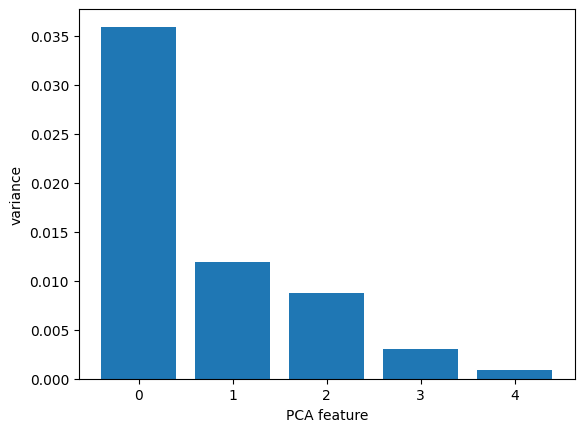

In [31]:
# Recreate train-test sets after recent feature engineering. 
X_train_models = df[df['set']=='train'].drop(columns=['rating', 'condition', 'date', 'drug0', 
                                                      'drug1', 'no_stop_cap_lemm', 'set'])
X_test_models =  df[df['set']=='test'].drop(columns=['rating', 'condition', 'date', 'drug0', 
                                                      'drug1', 'no_stop_cap_lemm', 'set'])
y_train_models = df[df['set']=='train']['rating']
y_test_models = df[df['set']=='test']['rating']

# Normalize data first, since the variables have a wide range of variances. 
scaler = MinMaxScaler()
scaler.fit(X_train_models)
X_train_scaled = scaler.transform(X_train_models)

# Perform PCA in order to select a number of features.
pca = PCA()
pca.fit(X_train_scaled)
features = range(pca.n_components_)

#Plot variances of PCA featuers
plt.bar(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.show()

A single feature explains most of the variance, but a non-negligibel amount of variance is also explained by the next two features. I can include pca as part of a pipeline and random grid search later, to explore the option of using all features or reducing down to 1-3 features. 

In [32]:
# Visualize variables' relationships with t-SNE
tsne = TSNE()
tsne_features = tsne.fit_transform(X_train_models)
X_train_models['tsne_x'] = tsne_features[:,0]
X_train_models['tsne_y'] = tsne_features[:,1]

<AxesSubplot: xlabel='tsne_x', ylabel='tsne_y'>

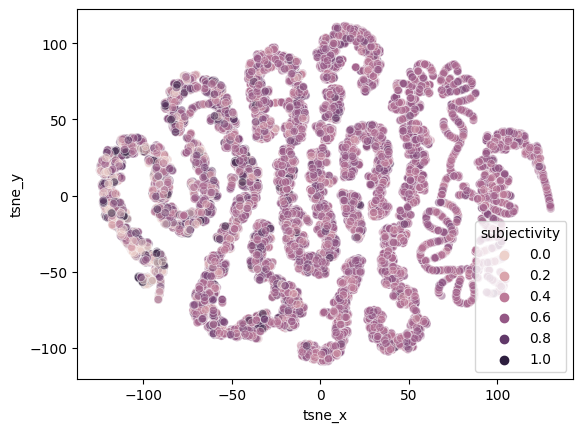

In [33]:
sns.scatterplot(data=X_train_models, x='tsne_x', y='tsne_y', hue='subjectivity', 
                alpha=0.5)

<AxesSubplot: xlabel='tsne_x', ylabel='tsne_y'>

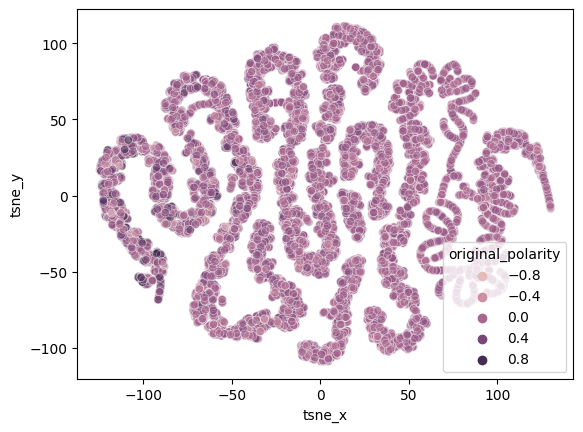

In [34]:
sns.scatterplot(data=X_train_models, x='tsne_x', y='tsne_y', hue='original_polarity', 
                alpha=0.5)

<AxesSubplot: xlabel='tsne_x', ylabel='tsne_y'>

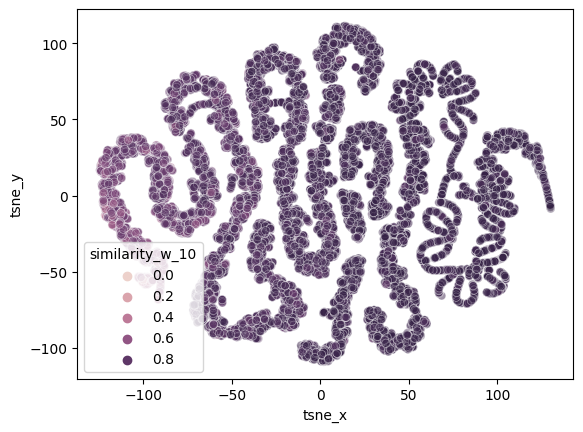

In [35]:
sns.scatterplot(data=X_train_models, x='tsne_x', y='tsne_y', hue='similarity_w_10', 
                alpha=0.5)

The three variables above used to hue the chart were the only ones with any perceptible difference across the visualization: subjectivity, polarity, and "similarity with 10". This is interesting but not especially helpful in determining whether/how to do dimensionality reduction. At any rate, with only 5 variables so far anyway, PCA should do just fine.  

Overfitting is always undesirable, but it is specifically important to avoid here because the later, unseen data will be unlabeled and I'll have little way of evaluating my models' performance on that unseen data. I'll therefore need to trust that I took all possible measures to avoid overfitting in the original model. I don't have very many features currently, but I could work to maintain model performance while reducing overfitting by engaging in recursive feature elimination. This could be done along with a random forest or gradient boosting classifier where I return feature importance values that can be used to potentially drop weak features one-by-one. This would be an alternative to PCA if PCA doesn't prove viable in my modeling pipeline. Come back to this option eventually as I have time or need. 

As mentioned here and further above, there are ways I could improve preprocessing with stronger word embedding or feature selection. But for now, move on with the current dataframe. In the next notebook, prepare for modeling by paring down to just the variables that will be able to be extracted from scraped psychedelic experience reports. Then, use a random grid search to find the best hyperparameters for PCA and for a number of potential classifiers, and in between PCA and the classifier include a count vectorizer to transform the column containing lemmatized text. 

<font color='violet'> Next Steps

Final model selection and tuning here: https://github.com/fractaldatalearning/psychedelic_efficacy/blob/main/notebooks/7-kl-studies-modeling.ipynb

In [36]:
df.to_csv('../data/processed/studies_w_vector_similarity.csv')

<font color='violet'> Notes

I drew some code from this article: 
- https://www.kaggle.com/code/abhishek/approaching-almost-any-nlp-problem-on-kaggle/notebook

Resources related to FastText:
- https://fasttext.cc/docs/en/python-module.html
- https://www.kaggle.com/code/grantgasser/eda-naive-bayes-bert-glove-fasttext-nn
- https://pythonwife.com/fasttext-in-nlp/
- https://towardsdatascience.com/fasttext-for-text-classification-a4b38cbff27c
- https://towardsdatascience.com/sarcasm-classification-using-fasttext-788ffbacb77b
- https://thinkinfi.com/fasttext-word-embeddings-python-implementation/

Other resources to check out:
- Try using huggingface based on example here: https://towardsdatascience.com/a-beginners-guide-to-use-bert-for-the-first-time-2e99b8c5423
- Try out spacy's visualizer: https://medium.com/acing-ai/visualizations-in-natural-language-processing-2ca60dd34ce  (Or visualize word embeddings with t-sne)
- Come back to this resource used in the previous notebook; it also contains info re: visualizing word embeddings: https://medium.com/plotly/nlp-visualisations-for-clear-immediate-insights-into-text-data-and-outputs-9ebfab168d5b
    